In [1]:
# Importing libraries

# For the PyTorch neural network:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.nn.modules.loss import BCEWithLogitsLoss

# For plots
import matplotlib.pyplot as plt

# Numpy is a handy way to deal with matrices and tensors
import numpy as np

# Utilities for preparing the dataset
import os
from PIL import Image


import torch
torch.manual_seed(5) # this makes the training reproducible: every training have the same initialization

from torchviz import make_dot

from torch.utils.data import DataLoader, TensorDataset

from torchview import draw_graph

import graphviz


In [2]:
import my_utilities as fun

In [3]:
parasitized_images=fun.load_images("../Dataset/parasitized/")
uninfected_images=fun.load_images('../Dataset/uninfected/')
model_folder="ZZRA3QModelResults/"
model_name="ZZRA3Q150Epochs"
nEp=150

../Dataset/parasitized/
../Dataset/uninfected/


In [4]:
#split data in 2 subsets: the first one is used for training and second one for validation
#also return 2 vectors (trainLabels and validationLabels) containing ones if the images is parasitized 0 else
#note that the last parameter is used to shuffle data
trainSet,valSet,trainLabels,validationLabels=fun.create_2_subsets(parasitized_images,uninfected_images,42)

#convert data to Torch tensor type (annoying but necessary)
trainSetTorch,validationSetTorch,trainLabelsTorch,validationLabelsTorch=fun.data_to_torch(trainSet,valSet,trainLabels,validationLabels)

#convert dato to dataLoader type
dataloader_train,dataloader_val=fun.create_dataloader_from_torchdata(trainSetTorch, trainLabelsTorch,validationSetTorch, validationLabelsTorch)



In [5]:
#Classic Model
# Defining a Net class, Module is imported from torch.nn and it is the parent class
class Net(Module): 
    #init is constructor method in phyton, self represents the instance
    def __init__(self):
        super(Net, self).__init__()

        # Defining layers that are specific of the CNN
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 5, kernel_size=5, stride=3, padding=4),
            BatchNorm2d(5), # A normalization layer (not important to study)
            ReLU(inplace=True), # The activation funcion (Rectified Linear Unit)
            MaxPool2d(kernel_size=2, stride=2), # Pooling layer
            # Defining another 2D convolution layer
            Conv2d(5, 5, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear=Sequential(
            Linear(125,10),
            ReLU(inplace=True),
            Linear(10, 2),
            #ReLU(inplace=True),
            )
        
        # Defining a normal layer of neurons (usually called Linear, Dense, or similar)
        self.linear2 = Sequential(
            #Linear(125, 10),
            #ReLU(inplace=True),
            # Dropout(0.1),
            #Linear(10, 4),
            #ReLU(inplace=True),
            Linear(2, 1),
            
            #ReLU(inplace=True),
            # Dropout(0.1),
        )

    # Defining the forward pass    
    def forward(self, x):
        # First, applying all the convolutional stuff
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1) # not important
        # Second applying all the linear layers (only one for now)
       
        x = self.linear(x)
        x = self.linear2(x)
        #x = Linear(2,1)(x)
        return x

In [6]:
# defining the model
model = Net()
#print(model)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)
# defining the loss function
loss_function = BCEWithLogitsLoss()

In [7]:
# defining the training function
def train(epoch, valSet, validationLabels, trainSet, trainLabels):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader_train): #enumerate method adds counter to an iterable and returns it. The returned object is an enumerate object
        #model(x) invokes the call method wich calls the forward method
        #in y_batch there is the label
        y_batch_prediction = model(x_batch)          
        y_batch = torch.reshape(y_batch, [y_batch.shape[0], 1])
        loss_train = loss_function(y_batch_prediction, y_batch)
        # train_losses.append(loss_train.detach().numpy())
        
        #clear gradients
        optimizer.zero_grad()
        
        #backpropagation, compute gradients
        loss_train.backward()
        
        #apply gradient
        optimizer.step()
   
    y_pred = model(valSet)
    validationLabels = torch.reshape(validationLabels, [validationLabels.shape[0], 1])
    loss_val = loss_function(y_pred, validationLabels)
    val_losses.append(loss_val.detach().numpy())

    y_pred = model(trainSet)
    trainLabels = torch.reshape(trainLabels, [trainLabels.shape[0], 1])
    loss_train = loss_function(y_pred, trainLabels)
    train_losses.append(loss_train.detach().numpy())

In [8]:
# defining the number of epochs
n_epochs = nEp
# empty list to store training losses
train_losses = []
accuracyTrainLosses=[]
# empty list to store validation losses
val_losses = []
# training the model
comodo=0
for epoch in range(n_epochs):
    comodo=comodo+1
    train(epoch, validationSetTorch, validationLabelsTorch, trainSetTorch, trainLabelsTorch)
    print(train_losses[epoch])
    scores_train = torch.sigmoid(model(trainSetTorch))[:,0]
    predictions_train = scores_train > 0.5
    accuracy_train = (predictions_train == trainLabelsTorch).sum()/ trainLabelsTorch.shape[0]
    print("accuracy on training set for epoch number "+str(comodo)+" ", accuracy_train.numpy())
    accuracyTrainLosses.append(accuracy_train.numpy())

0.69600844
accuracy on training set for epoch number 1  0.505
0.69545335
accuracy on training set for epoch number 2  0.505
0.69484633
accuracy on training set for epoch number 3  0.505
0.6935205
accuracy on training set for epoch number 4  0.505


In [9]:
# PARTE QUANTISTICA
#------------------------------------------------------------------------------------------------------------------------

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from numpy import pi
import time

def create_qnn():
    feature_map = ZZFeatureMap(3)
    ansatz = RealAmplitudes(3, reps=1)
    #print(feature_map.parameters)
    #paramToTrain = ParameterVector('par', 3)
    #print(param1)
    
    qc = QuantumCircuit(3)
    qc.compose(ansatz, inplace=True)
    qc.compose(feature_map, inplace=True)
    
    print(qc)
    qc.draw('mpl')

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters ,
        input_gradients=True,
    )
    return qnn

In [10]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        # Defining layers that are specific of the CNN
        self.cnn_layers = Sequential(
             # Defining a 2D convolution layer
            Conv2d(1, 5, kernel_size=5, stride=3, padding=4),
            BatchNorm2d(5), # A normalization layer (not important to study)
            ReLU(inplace=True), # The activation funcion (Rectified Linear Unit)
            MaxPool2d(kernel_size=2, stride=2), # Pooling layer
            # Defining another 2D convolution layer
            Conv2d(5, 5, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        # Defining a normal layer of neurons (usually called Linear, Dense, or similar)
        self.linear_layers = Sequential(
            Linear(125, 10),
            ReLU(inplace=True),
            # Dropout(0.1),
            Linear(10, 3),
            #ReLU(inplace=True),
            # Dropout(0.1),
        )
        self.qnn = TorchConnector(qnn) 
        self.linear_layers2 = Sequential(
            Linear(1,1),
        )

    # Defining the forward pass    
    def forward(self, x):
        # First, applying all the convolutional stuff
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1) # not important
        # Second applying all the linear layers (only one for now)
        x = self.linear_layers(x)
        x = self.qnn(x)
        #x = self.linear_layers2(x)
        return x

In [11]:
# defining the model
qnn=create_qnn()

model4 = Net()
graficoModelloIbrido = draw_graph(model4, input_size=(1, 1, 64, 64), save_graph= True, filename = "cnn_architecture")
#show the architecture
graficoModelloIbrido.visual_graph
print(model4)
# defining the optimizer
optimizer = Adam(model4.parameters(), lr=0.0001)
# defining the loss function
criterion = BCEWithLogitsLoss()

     ┌────────────────────────────────────────────────┐»
q_0: ┤0                                               ├»
     │                                                │»
q_1: ┤1 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) ├»
     │                                                │»
q_2: ┤2                                               ├»
     └────────────────────────────────────────────────┘»
«     ┌───────────────────────────────┐
«q_0: ┤0                              ├
«     │                               │
«q_1: ┤1 ZZFeatureMap(x[0],x[1],x[2]) ├
«     │                               │
«q_2: ┤2                              ├
«     └───────────────────────────────┘



(process:14600): Pango-WARNING **: 14:25:54.225: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(3, 3), padding=(4, 4))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=125, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
  (qnn): TorchConnector()
  (linear_layers2): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)


In [12]:
# defining the number of epochs
epochs = nEp
# empty list to store training losses
train_lossesq = []
# empty list to store validation losses
val_lossesq = []
accuracyTrainLossesq=[]
toc=0
tic=0
# training the model
for epoch in range(epochs):
    print("epoca")
    total_loss=[]
    tic=time.perf_counter()
    for id_batch, (data, label) in enumerate(dataloader_train):
        optimizer.zero_grad(set_to_none=True)
        nComodo=nComodo+1
        output=model4(data)
        label=torch.reshape(label,[label.shape[0], 1])
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    toc = time.perf_counter()
    print(f" time :  {toc - tic:0.4f} seconds")
    train_lossesq.append(sum(total_loss)/len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, train_lossesq[-1]))
    y_pred = model4(validationSetTorch)
    validationLabels = torch.reshape(validationLabelsTorch, [validationLabelsTorch.shape[0], 1])
    loss_val = loss_function(y_pred, validationLabels)
    val_lossesq.append(loss_val.detach().numpy())
    scores_train = torch.sigmoid(model4(trainSetTorch))[:,0]
    predictions_train = scores_train > 0.5
    accuracy_train = (predictions_train == trainLabelsTorch).sum()/ trainLabelsTorch.shape[0]
    print("accuracy on training set for epoch number "+str(epoch)+" ", accuracy_train.numpy())
    accuracyTrainLossesq.append(accuracy_train.numpy())

epoca
0.0
 time :  20.4064 seconds
Training [25%]	Loss: 0.6892
accuracy on training set for epoch number 1  0.54875
epoca
1.0
 time :  14.8343 seconds
Training [50%]	Loss: 0.6840
accuracy on training set for epoch number 2  0.56875
epoca
2.0
 time :  12.3127 seconds
Training [75%]	Loss: 0.6804
accuracy on training set for epoch number 3  0.585
epoca
3.0
 time :  13.2973 seconds
Training [100%]	Loss: 0.6769
accuracy on training set for epoch number 4  0.59375


In [22]:
print(len(train_lossesq))
print(len(val_lossesq))

4
4


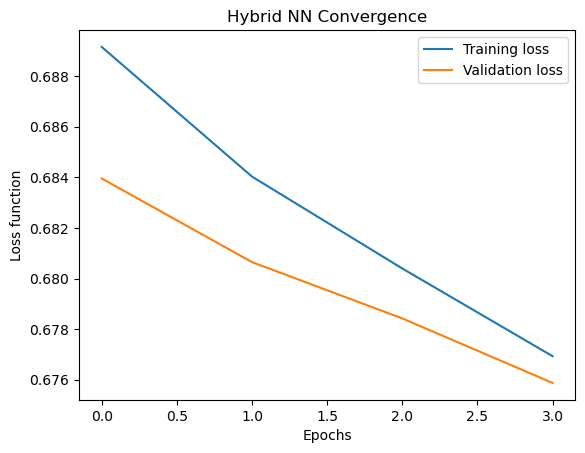

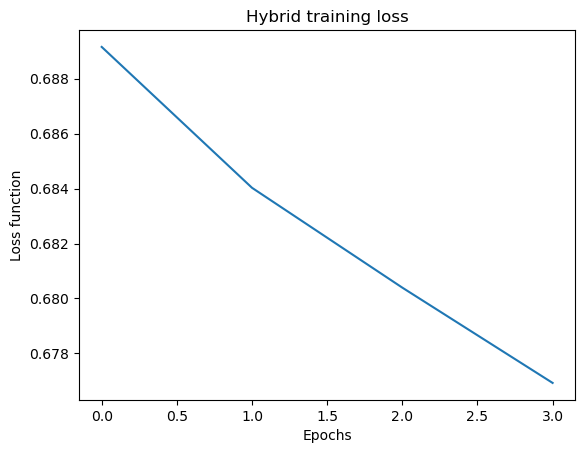

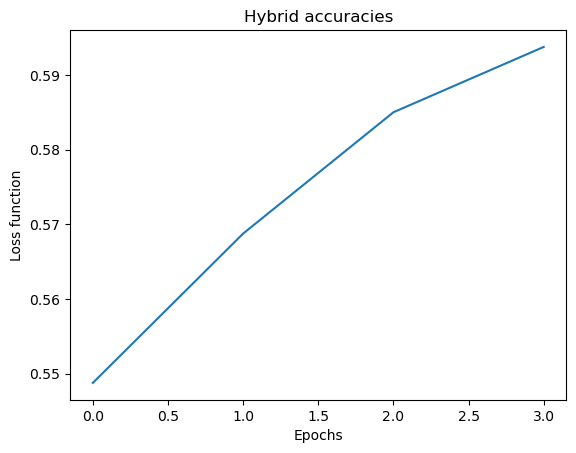

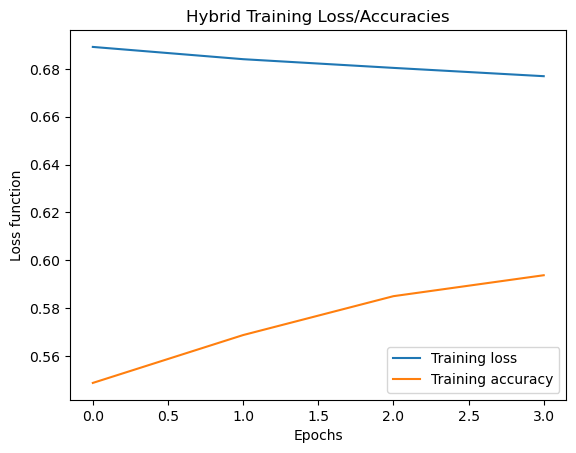

In [25]:

# plotting the training and validation loss
#GRAPHS

#------loss-validation/training-----
plt.plot(train_lossesq, label='Training loss')
plt.plot(val_lossesq, label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title("Hybrid NN Convergence")
#plt.yscale("log")
plt.savefig(model_folder+model_name+"LVThybrid.png")
plt.show()
#------loss-validation---------

plt.figure()
plt.title('Hybrid training loss')
plt.plot(train_lossesq, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
#plt.savefig(hybridModelFolder+hybridModelName+"LThybrid.png")
plt.show()
#------accuracies-training--------
plt.figure()
plt.plot(accuracyTrainLossesq, label='Accuracy training')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Hybrid accuracies')
plt.savefig(model_folder+model_name+"AThybrid.png")
plt.show()
#-----total-----
plt.figure()
plt.title('Hybrid Training Loss/Accuracies')
plt.plot(train_lossesq, label='Training loss')
plt.plot(accuracyTrainLossesq, label='Training accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.savefig(model_folder+model_name+"ALTVhybrid.png")
plt.show()

In [26]:
scores_train = torch.sigmoid(model4(trainSetTorch))[:,0]
scores_val = torch.sigmoid(model4(validationSetTorch))[:,0]

predictions_train = scores_train > 0.5
predictions_val = scores_val > 0.5
accuracy_train = (predictions_train == trainLabelsTorch).sum()/ trainLabelsTorch.shape[0]
accuracy_val = (predictions_val == validationLabelsTorch).sum()/ validationLabelsTorch.shape[0]

print("accuracy on training set: ", accuracy_train.numpy())
print("accuracy on validation set: ", accuracy_val.numpy())


accuracy on training set:  0.59375
accuracy on validation set:  0.6


In [27]:
accuraciesLoss=[]

In [30]:
# Saving data
with open(model_folder + model_name + ".txt", 'w') as fp:
    # Writing training losses
    fp.write("train_losses hybrid:\n\n")
    fp.writelines("%s\n" % item for item in train_lossesq)
    print('Train losses saved')

    # Writing validation losses
    fp.write("\nval_losses hybrid:\n\n")
    fp.writelines("%s\n" % item for item in val_lossesq)
    print('Val losses saved')

    # Writing accuracies
    fp.write("\naccuracies hybrid:\n\n")
    fp.writelines("%s\n" % item for item in accuracyTrainLossesq)
    print('Accuracies saved')

    # Writing accuracy on training
    fp.write("\naccuracy on training HYBRID:")
    fp.write(str(accuracy_train.numpy()))
    print('Accuracy on training saved')

    # Writing accuracy on validation
    fp.write("\naccuracy on validation HYBRID:")
    fp.write(str(accuracy_val.numpy()))
    print('Accuracy on validation saved')

# Saving the hybrid model
torch.save(model4, model_folder + model_name + "Hybrid.pt")
print('Hybrid model saved')


Train losses saved
Val losses saved
Accuracies saved
Accuracy on training saved
Accuracy on validation saved
Hybrid model saved


In [31]:
hybridModel = torch.load(model_folder+model_namehybridModelName+"Hybrid.pt")

In [32]:
scores_val = torch.sigmoid(hybridModel(validationSetTorch))[:,0]
predictions_val = scores_val > 0.5
accuracy_val = (predictions_val == validationLabelsTorch).sum()/ validationLabelsTorch.shape[0]

In [33]:
print("accuracy on validation set: ", accuracy_val.numpy())

accuracy on validation set:  0.6


In [36]:
#--------test part---------
import funForTest as fun2
parasitized_images=fun2.load_images("../DatasetTest/pTest/")
uninfected_images=fun2.load_images('../DatasetTest/uTest/')
test_set,test_lb=fun2.create_2_subsets(parasitized_images,uninfected_images,42)
test_set_torch  = torch.from_numpy(test_set).float()
test_lb_torch  = torch.from_numpy(test_lb).float()
    
#convert data to Torch tensor type (annoying but necessary)

print(len(test_set_torch))
scores_test = torch.sigmoid(hybridModel(test_set_torch))[:,0]
predictions_test = scores_test > 0.5
accuracy_test = (predictions_test == test_lb_torch).sum()/ test_lb_torch.shape[0]
print("accuracy on test set: ", accuracy_test.numpy())

../DatasetTest/pTest/
../DatasetTest/uTest/
400
accuracy on test set:  0.595
